# XGBoost Setup
Import relevant libraries and setup our dataframe.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix,classification_report

df = pd.read_csv("../Data/Transformed_Student_Performence_Data.csv")

X = df.drop("GradeClass", axis=1)
y = df["GradeClass"]

# Train Model
Split our train and test data to then fit the model with the weighted classes.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

model = xgb.XGBClassifier(
	# this objective is used for multi-class classifcation problems, which is what we have
	# https://xgboosting.com/configure-xgboost-multisoftprob-objective/
	objective="multi:softprob",
	learning_rate=0.1,
	# 6 is the default and a decent value, increasing depth too much could overfit
	max_depth=6,
	n_estimators=100,
	# seed keeps our results the same, 42 happens to be the answer to life
	random_state=42,
	scale_pos_weight=1,
)

sample_weights = np.array([class_weight_dict[i] for i in y_train])
model.fit(X_train, y_train, sample_weight=sample_weights)

y_pred = model.predict(X_test)

C:\Users\Cash\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [14:20:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Evaluation
Classification report provides model accuracy and normalised confusion matrix provides visual overview of the model's performance across it's predictions.

In [3]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.44      0.52        16
           1       0.58      0.61      0.59        49
           2       0.61      0.61      0.61        80
           3       0.58      0.62      0.60        85
           4       0.93      0.92      0.92       249

    accuracy                           0.77       479
   macro avg       0.67      0.64      0.65       479
weighted avg       0.77      0.77      0.77       479



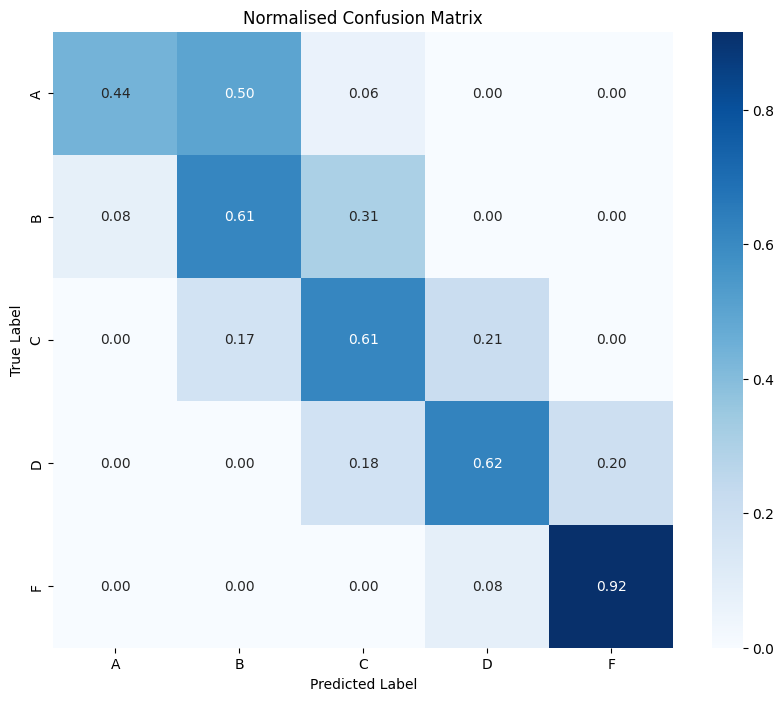

In [4]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

grade_classes = ["A", "B", "C", "D", "F"]
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
	xticklabels=grade_classes,
	yticklabels=grade_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised Confusion Matrix")
plt.show()